<b style='font-size: 14px;'>Table of Content</b><ol><li>Introduction: OCR and Logistic Regression</li><li>Loading and visualizing the data</li><li>Part I: Logistic Regression</li><ol><li>Likelihood</li><li>Gradient descent</li><ol><li>(Batch) Gradient Descent</li><li>Stochastic gradient descent</li><li>Minibatch stochastic gradient descent</li></ol><li>Deliverables</li><ol><li>Report</li><li>Theoretical Questions</li></ol></ol><li>Part II: Multinomial/Softmax  Regression</li><ol><li>Numerical Issues with Softmax</li><li>Deliverables</li><ol><li>Report</li><li>Theoretical Question(s):</li></ol></ol><li>Uploading to BlackBoard</li></ol>
<hr>

Report length is 5 pages. You are allowed to be up to 3 members in a group.  



# 1. Introduction: OCR and Logistic Regression
In this handin you will build classifiers for optical character recognition (OCR) using **Logistic Regression** and **Softmax**. The classifier will take images of numbers as input and output which number the image represent. The input images will look like those below for which the classifier (hopefully) will predict the numbers 5041.

   <img src="https://tensorflow.rstudio.com/images/MNIST.png" style="width:200px;" /> 

The handin is split into two parts. Each part uses a different model for learning. The first considers *logistic regression* and the second considers *softmax*. These will both be explained later. 

We have compiled a list of tips, tricks and common coding mistakes in the <a href="https://blackboard.au.dk/webapps/discussionboard/do/message?action=list_messages&course_id=_66530_1&nav=discussion_board_entry&conf_id=_121247_1&forum_id=_92703_1&message_id=_146625_1">discussion board</a>. 

The performance of your final classifier is easy to compare. This year we made a highscore board where you can see the scores of your fellow students. This is only for fun and will not be a part of judging your handin, but we encourage you to try and beat the TA classifier ;-)


In [4]:
from IPython.display import IFrame
IFrame('https://cs.au.dk/~alexmath/highscore.php', width=500, height=220, border=0)


# 2. Loading and visualizing the data
We will use the AU-Digits data set generated by previous Machine Learning students here at Aarhus University. 
The following code loads the data into two sets: the *training* and the *test* set.


In [1]:
%matplotlib inline
import numpy as np
import os
import matplotlib.pyplot as plt
import urllib

def load_train_data():
    filename = "auTrain.npz"
    if not os.path.exists(filename):
        #os.system('wget https://users-cs.au.dk/jallan/ml/data/auTrain.npz')
        with open(filename,'wb') as fh:
            fh.write(urllib.request.urlopen("https://users-cs.au.dk/jallan/ml/data/%s" % filename).read())

    tmp = np.load(filename)
    return tmp['digits'], tmp['labels']

def load_test_data():
    filename = "auTest.npz"
    if not os.path.exists(filename):
        #os.system('wget https://users-cs.au.dk/jallan/ml/data/auTest.npz')
        with open(filename,'wb') as fh:
            fh.write(urllib.request.urlopen("https://users-cs.au.dk/jallan/ml/data/%s" % filename).read())
        
    tmp = np.load(filename)
    return tmp['digits'], tmp['labels']

images, labels = load_train_data()
images_test, labels_test = load_test_data()


The data is now loaded. The following code visualizes some of the images. You might find this handy later on. 

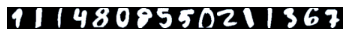

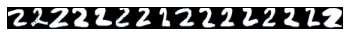

In [2]:
import matplotlib.pyplot as plt

# Visualize the first 16 digits from training set
x = images[0:16, :].reshape(-1, 28, 28)
x = x.transpose(1, 0, 2)
plt.imshow(x.reshape(28, -1), cmap='bone')
plt.yticks([])
plt.xticks([])
plt.figure()

# Visualize the first 16 two's from training set
# HINT: You might want to try to visualize the first 10 seven's. 
idx1 = (labels == 2)
img2s = images[idx1, :]
x2 = img2s[0:16, :].reshape(-1, 28, 28)
x2 = x2.transpose(1, 0, 2)
plt.imshow(x2.reshape(28, -1), cmap='bone')
plt.yticks([])
plt.xticks([])

plt.show()

# 3. Part I: Logistic Regression
In supervised machine learning the goal is to learn a target function $f: X\rightarrow Y$. If we model $f$ deterministically each $x$ has exactly one correct label $y$ which is given by $y=f(x)$. In Logistic Regression things are a bit different. Here, we model the the target function as a probability distribution $f(x)=\Pr(y\mid x)$. Therefore each $x$ does not have one correct label, each $x$ has a corresponding probability for each $y$. 

<div style="border: 1px solid black; margin:16px; padding: 16px; "><b>Example</b>: 
Given an image $x$ like the following

<img src="http://users-cs.au.dk/jallan/ml/exercises/handin1/figs/twoorseven.png"><br>

It is not entirely clear if this image is a 2 or a 7. In Logistic Regression $f(x)$ is a probability distribution and we might thus get something like <br><br>

  $\quad\quad f(x)=\Pr(y\mid x)=[0.05, \;0.00,\; 0.40,\; 0.02,\; 0.01,\; 0.00,\; 0.03,\; 0.42,\; 0.02,\; 0.05]$<br><br>

This means that the probability of $x$ being a 2 is 40%, the probability of 7 is 42% and so on. This stands in contrast to just outputting 7. </div> 

To this end we use the logistic function

$$\sigma(z) = \frac{1}{1+e^{-z}}\quad\quad\text{where}\quad\quad z = \sum_{i=0}^d \theta_i x_i = \theta^\intercal x$$

You need to notice two things here: 
   1. $z$ is a linear combination of the input and the vector $\theta$. The goal of learning is to find good values for $\theta$.
   2. The bias variable is encoded into the input vectors as $x_0=1$ on all data points (this is similar to what we did in lectures and previous exercises, if this confuses you re-read pages 5-7). 

The following code plots the logistic function $\sigma(z)$. 

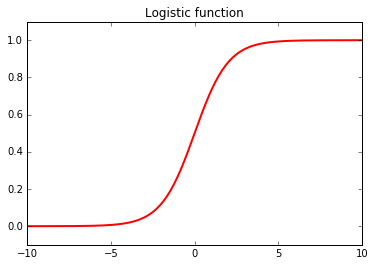

In [4]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

def sigmoid(x):
    return 1/(1 + np.exp(-x))

x = np.linspace(-10, 10, 200)
plt.plot(x, sigmoid(x), 'r', linewidth=2)
plt.axis([-10, 10, -0.1, 1.1])
plt.title('Logistic function')

plt.show()

The model then becomes,

$$
p(y \mid x, \theta) = \left \{
\begin{array}{l l}
  \sigma(\theta^\intercal x)
  & \text{ if } y=1  \\
  1 - \sigma(\theta^\intercal x)
  & \text { if } y=0,
\end{array}
\right.
$$

That is, the probability that $y = 1$ given $x$ and $\theta$
is $\sigma(\theta^\intercal x)$. Similarly, the probability that $y=0$ given $x$ and $\theta$ is $1-\sigma(\theta^\intercal x)$. It is then possible to use the function $p$ to make classification by returning the most likely class. That is, compute both probabilities and return the most probable one. 

It is important that you notice this function depends heavily on $\theta$. If we want any kind of success in classifying with $p$, we need to learn values of $\theta$ such that $p$ has little error. 

<div style="border: 1px solid black; margin: 16px; padding: 16px; "><b>Fact: </b>The logistic function has a very simple derivative<br><br>

$$\frac{\partial \sigma }{\partial z} = (1-\sigma(z))\sigma(z)$$<br>

This is one of our main reasons for choosing this function, it makes everything a lot easier.
</div>

## 3. A. Likelihood

The dataset has the form $D = (X, Y) = \{(x_i, y_i) \mid i = 1, \dots, n \}$, where $x_i \in \{1\} \times \mathbb{R}^d$ is the $(d+1)$-dimensional data point (with the first dimension used for the bias 1) and $y_i \in \{0,1\}$ is its label. For convinience we construct the following data matrix $X$ and label vector $y$

$$X=\begin{pmatrix} 
1&- & x_1 & - \\
\vdots & \vdots & \vdots \\
1&- & x_n & - \\
\end{pmatrix}\in \mathbb{R}^{n \times (d+1)}\quad\quad 
y=\begin{pmatrix}
y_1\\
\vdots\\
y_n\end{pmatrix}\in\{0,1\}^n$$

It is important that you notice that the entries $y_i$ of $y$ are not probabilities, but instead actual realisation of events.

We assume (as always) that the points in $D$ are independently sampled from the unknown input distribution.
This means that under our model, for a fixed parameter vector $\theta$, the likelihood of the data is precisely

$$\begin{align}
p(D \mid \theta)
&= \prod_{(x,y)\in D}
  p(y \mid x,\theta)\\
&= \prod_{(x,y)\in D}
  \sigma(\theta^\intercal x )^{y}
  (1-\sigma(\theta^\intercal x))^{1-y}
  \end{align}
$$

The first equality follows from independence. The second equality uses that $p(y\mid x, \theta)=\sigma(\theta^\intercal x )^{y}
  (1-\sigma(\theta^\intercal x))^{1-y}$. You should convince yourself that this is true; try look at both cases $y=0$ and $y=1$. This gives a convenient way of expressing
the probability $p(y \mid x,\theta)$ as a product.

As derived in class the negative log likelihood (<a href="https://en.wikipedia.org/wiki/Cross_entropy">cross entropy</a>) is:

$$\begin{align}
\mathrm{NLL}(D\mid \theta)
&= -\log{p(D\mid\theta)}\\
&=- \sum_{i=1}^n
y_i \ln(\sigma(\theta^\intercal x_i)) +
(1-y_i) \ln(1-\sigma(\theta^\intercal x_i))
\end{align}$$

Notice that one of the two terms inside the sum is zero every time because $y_i\in\{0, 1\}$.


The gradient (vector) is

$$
\nabla \mathrm{NLL}(D \mid \theta)
= \frac{\partial \mathrm{NLL}}{\partial \theta}
= -X^\intercal(Y-\sigma(X\theta))
$$

We define the error we want to minimize to be $E_\textrm{in} = \frac{1}{n} \mathrm{NLL}$. The gradient of the error is then $\nabla E_\textrm{in} = \frac{1}{n} \nabla \mathrm{NLL}$ which is given above. The goal is now to find a good $\theta$ such that we minimize the in-sample error $E_{in}$. In this exercise you must do this by implementing a gradient descent algorithm as explained in the next section. 


## 3. B. Gradient descent
There a several variations of Gradient Descent. They all attempt to solve the following optimization problem: 

<p style="text-indent: 16px;">Given a function $F(\theta)$ find $\theta$ that approximately minimizes $F$. </p>

In some simple cases we can differentiate $F(\theta)$ and solve $F'(\theta)=0$ for $\theta$. This will give us the optimal solution $\theta^*$ which by far is better than any approximation. Unfortunately, this is often not possible for the functions we care about in this course.  

All variations of <a href="https://en.wikipedia.org/wiki/Gradient_descent">Gradient Descent</a> follow the same iterative methods:

1. Find initial $\theta_0$ (could be initialized randomly)
2. Repeat for $t=1,\ldots,T$
3. $\quad\quad$Compute the gradient $g_t=\nabla_{\theta} f(\theta_t)$
4. $\quad\quad$Take a step in the direction of the negative gradient $\theta_{t+1}=\theta_t - \eta\cdot \nabla_{\theta} f(\theta_t)$

Here $\eta$ is called the *step size* or the *learning rate*. The size of $\eta$ is often set by experimenting with different values in practice. 

<img src="http://i.imgur.com/uqKsueE.jpg" style="width: 300px;" />

There is a similar figure in the book page 94. Too small $\eta$ is inefficient when we are too far from the local minima. Too large $\eta$ is undesirable when we are too close to the local minima. This problem is sometimes solved by having a decreasing step size. In this handin it will be sufficient to use a fixed step-size, but you are free to experiment with varying step size.

<!--If $F$ is <a href="https://en.wikipedia.org/wiki/Convex_function">convex</a> gradient descent (any theoretical guarantees). If the function is not convex we risk getting stuck at local optima. In practice this is resolved by running Gradient Descent multiple times (e.g. Neural Networks). -->


### 3. B. a. (Batch) Gradient Descent
The function we would like to minimize is the in-sample error $E_{in}$. That is we want to find $\theta$ that minimize $F(\theta)=E_{in}(\theta)$. But the in-sample error rate is often defined as the point-wise errors of all examples $(x_i, y_i)$ in our data set. Thus, evaluating $\nabla_\theta F(\theta_t)$ in step 3 of gradient descent will take $O(n)$ time where $n$ is the size of our dataset (i.e. we have to look at all training examples). This is called <b>Batch</b> Gradient Descent because the gradient $\nabla F(\theta_i)$ is evaluated on the entire data set. 

Stochastic Gradient Descent attempts to speed up this process by not looking at the entire dataset. 

### 3. B. b. Stochastic gradient descent
Each iteration of Batch Gradient Descent needs to consider the entire data set to compute the gradient. This often makes every iteration very slow. **Stochastic gradient descent** (SGD) is a much faster method that uses randomization to avoid looking at all the data points in each step.

In SGD, our cost function $F$ must be an average over all the points, that is, a function on the form $F(\theta) = \frac{1}{n} \sum_{i = 1}^n F_i(\theta)$. Notice that this is the case for logistic regression considered above.
When the cost function is an average, the gradient of the cost becomes 

$$\nabla F(\theta) = \frac{1}{n} \sum_{i=1}^n \nabla F_i(\theta) = E_{i}[\nabla F_i(\theta)]$$

In SGD we estimate $\nabla F(\theta)$ by picking a random data point $i$ and computing $\nabla F_i(\theta)$. This is an <a href="https://en.wikipedia.org/wiki/Bias_of_an_estimator">unbiased estimator</a> for $\nabla F(\theta)$ (i.e. they have same expected value) which we can use instead of $\nabla F(\theta)$ at each iteration.

In practice we will not sample a random $i$ at each iteration, but approximate the above method by running multiple so-called *epochs* where the data is processed in a random order. At the beginning of each epoch, we output the current true value of $F(\theta)$, and we <a href="https://docs.scipy.org/doc/numpy/reference/generated/numpy.random.shuffle.html">shuffle</a> the data set before processing each data point as above.

### 3. B. c. Minibatch stochastic gradient descent

In SGD described above, the estimate of $\nabla F(\theta)$ has a high <a href="https://en.wikipedia.org/wiki/Variance">variance</a> since it only considers a single data point $i$. The idea of minibatch SGD is to sample more than one point from the dataset when estimating the gradient. The idea is that this decreases the variance while maintaining the advantage of each iteration being fast. Namely, we pick a minibatch size $k$ (typically between 10 and 50) and sample $i_1, i_2, \dots, i_k$, and then we compute the better estimator (in terms of variance) $\frac{1}{k} \sum_{j=1}^k \nabla F_{i_j}(\theta)$ for $\nabla F(\theta)$. 

As for SGD, in practice we will approximate this by running epochs where the data is shuffled at the beginnning of each epoch, after which all datapoints are processed $k$ at a time in the shuffled order. 

As explained in the book page 93 it is required that $F$ be twice differentiable. Does it matter if $F$ is <a href="https://en.wikipedia.org/wiki/Convex_function">convex</a> when we run Gradient Descent? (HINT: re-read page 93) 

## Deliverables
<ol>
<li>In the file "*logistic_regression.py*" you should complete the following methods 
<ol>
<li>logistic</li> 
<li>log_cost</li>
<li>batch_grad_descent</li>
<li>mini_batch_grad_descent</li>
</ol>
You can test your implementation by running "*python logistic_regression.py*". This is a small non-exhaustive test. Consider writing your own test cases.  
</li>

<br><li>In "*h1_classifiers.py*" there is a class 'LogisticClassifierTwoClass'. This is a binary classifier, that is, it classifies between two classes like determining if an image is 2 vs 7. You should 
<ol>
<li>Finish the implementation of all methods of LogisticClassifierTwoClass.</li>
<li>Finish the implementation of the function 'model_accuracy'. </li>
<li>At this point you will have working code that can perform binary classification. Test this by running "*python model_stats.py -log*" (this might take a few minutes). This outputs 3 csv files **results_2_vs_7.csv**, **pairwise_scores_train.csv** and **pairwise_scores_test.csv** you should include in your report. 
 <li>The parameter vector of your 2 vs 7 classifier is visualized as a picture **logistic_regreesion_two_class_parameter_plot_1_128.png**. Does it look like something you recognize? Why is that? </li>
</ol>
</li>

<br><li>In "*h1_classifiers.py*" there is another class LogisticClassifier. This is the final classifier that should learn how to classify inputs from all 10 classes (it is a full digit OCR classifier). 
<ol>
<li>Implement the lacking methods of the LogisticClassifier class by using the <a href="https://en.wikipedia.org/wiki/Multiclass_classification#One-vs.-rest">all-vs-one</a> technique.  
</li> 
<li>Re-run "*python model_stats.py -log*". The results are stored in files **logistic_regression_classification_report.csv**, **logistic_regression_confusion_matrix.csv**, **logistic_regression_accuracy.csv**, and the visualization of the learned parameter vectors in **logistic_regression_two_class_parameter_plot_1_128.png** which again must be included in your report.</li>
</ol>
</li>

<br><li>
Improving the final classifier:
<ol>
<li>Add regularization to the cost function *log_cost* in "*logistic_regression.py*". Remember not to apply regularization to the bias parameter. </li>
<li>Implement validation by completing *run_validation* in "*h1_classifiers.py*" </li>
<li>Find the best parameter settings for regularization by specfying different *reg* values in *best_model* in "*model_stats.py*" and run "*python model_stats.py -log_val*". This outputs the results
 **logistic_regression_validation_scores.csv**, **logistic_regression_best_result.csv** also to be included in your report.<br><br>

HINT: values are often exponentially decreasing like [0.3\*\*i for i in range(10)]. </li>
</ol>
</li>
</ol>

You can now upload your score to the highscore list by running "*python upload_score.py STUDY_ID GROUPNAME*".  

### Report
Add a section called "PART I: Logistic Regression" with subsections "Code" and "Theory" to your report. In the code subsection you should have the following subsubsections
<ol>
<li>Summary: Briefly explain the results you achieve and any issues you encountered.</li>
<li>Results and plots: As stated above you should include all the results and plots your algorithms produced. Comment anything you believe sticks out, but use only few lines per plot. </li>
<li>Weight Parameter: Specifically for weight parameters (the <b>.png</b> images), you should write three lines describing why you think they look the way they do. </li>
<li>Best Parameters: 
State the regularization parameters you used for the best classifier you found and state the accuracy on the test set for the best model you trained.</li>
</ol>

Furthermore you must answer the following theoretical questions
(although the bonus question is optional).

### Theoretical Questions
<ol>
<li>What is the running time of your batch gradient descent and your mini gradient descent algorithm?<br><br>
  
  The parameters:<br>
  * n*: number of training samples<br>
  * d*: dimensionality of training samples<br>
  * epochs*: number of epochs run<br>
  * mini_batch_size*: batch_size for mini_batch_gradient_descent<br><br>
  
  Write both the time to compute the cost and the gradient for log_cost</li>

<br><li> What is the running time of your implementation of logistic regression for two classes? For K classes? </li>

<br><li>Sanity Check:<br>
  What happens if we randomly permute the pixels in each image (with the same permutation) before we train the classifier? Will we get a classifier that is better, worse, or the same? Give a short explanation (at most three sentences)<br><br>
  HINT: The location of pixels relative to each other seem to hold some kind of information. Does a random permutation of all pixels position affect this locality? Does the model we use exploit pixel locality?</li>

<br><li>(BONUS) Linear Separable:<br>
  If the data is linearly separable, what happens
  to weights when we implement logistic regression with gradient
  descent? That is, how do the weights that minimize the negative log likelihood look like?<br><br>
  You may assume that we have full precision (that is, ignore floating point errors) and we can run gradient descent as long as we want (i. e. what happens with the weights in the limit). <br>

  Do they converge to some fixed number (fluctuate around it) or do they
  keep increasing in magnitude (absolute value)?<br>

  Give a short explanation for your answer (you may include math).(at most 5 lines)<br>

  What happens if we add regularization?


# Part II: Multinomial/Softmax  Regression

In this exercise we generalize logistic regression to handle $K$
classes instead of 2. This is known as Multinomial regression or Softmax.
We will use the exact same approach as for logistic
regression, but it becomes a little more technical due to the extra
classes.

With Softmax we are classifying into $K$ classes (instead
of 2 for logistic regression). For this exercise we encode the target values, $y$, as a vector of
length $K$ with all zeros except one which corresponds to the class (one-in-K encoding).
If an example belong to class 3 and there are five classes then
$y = [0,0,1,0,0]^\intercal = e_3$.

So $Y$ is now a matrix of size $n \times K$, and the data matrix $X$ is unchanged.

$$X=\begin{pmatrix} 
1&- & x_1^T & - \\
\vdots & \vdots & \vdots \\
1&- & x_n^T & - \\
\end{pmatrix}\in \mathbb{R}^{n \times (d+1)}\quad\quad 
y=\begin{pmatrix}
- & y_1^T & -\\
- & \vdots &- \\
- & y_n^T & -\end{pmatrix}\in\{0,1\}^{n\times K}$$

We can no longer use the logistic function as the probability function.
Instead we use a generalization which is the *softmax* function.
Softmax takes as input a vector of length $K$
and outputs another vector of the same length $K$,
that is a mapping from the $K$ input numbers into $K$
*probabilities*, e.g. they sum to one.  Softmax is defined as

$$
\textrm{softmax}(x)_j =
\frac{e^{x_j}}
{\sum_{i=1}^K e^{x_i}}\quad
\textrm{ for }\quad j = 1, \dots, K.
$$

Notice that the denominator acts as a normalization term that ensures
that the probabilities sum to one. Again we get nice derivatives,

$$
\frac
{\partial \;\textrm{softmax}(x)_i}
{\partial x_j} =
(\delta_{i,j} - \textrm{softmax}(x)_j)
\textrm{softmax}(x)_i\quad\quad\text{where}\quad\quad
\delta_{ij}=\begin{cases}1 &\text{if }i=j\\
0 & \text{else}
\end{cases}
$$

Exactly as before this is a linear model for each class. The parameter set
$\theta$ is represented as a $(d+1) \times K$ matrix giving $d+1$
parameters (+1 for the bias) for each of the $K$ classes (parameters
for class $c$ is column $c$), meaning that
$\theta=[\theta_1,\ldots,\theta_K]$. We get

$$
p(y \mid x,\theta) =
\textrm{softmax}(\theta^\intercal x) =
 \left \{
\begin{array}{l l}
 \textrm{softmax}(\theta^\intercal x)_1 & \text{ if } y = e_1,  \\
 \vdots & \\
 \textrm{softmax}(\theta^\intercal x)_K & \text { if } y = e_K.
\end{array}
\right.
$$

Think of the probability distribution over $y$ as throwing a $K$-sided die
where the likelihood of landing on each of the $K$ sides is stored in the
vector $\textrm{softmax}(\theta^\intercal x)$ (which is a vector of length $K$) and the
probability of landing on side $i$ is $\textrm{softmax}(\theta^\intercal x)_i$. 



In [1]:
x = np.array([1, 1, 1])
softmax = np.exp(x)/np.sum(np.exp(x))
print('softmax of the ones vector: ', softmax)
print('That seems resonable, right?')

NameError: name 'np' is not defined

As for logistic regression we compute the likelihood of the data given a fixed matrix of parameters.
We use the notation $[z]$ for the indicator function e.g. $[z]$ is one if $z$ is true and zero otherwise.

$$
P(D \mid \theta) =
\prod_{(x,y)\in D}
\prod_{j=1}^K
\textrm{softmax}(\theta^\intercal x)_j^{[y_j=1]}
=
\prod_{(x,y)\in D}
y^\intercal
\textrm{softmax}(\theta^\intercal x)
.
$$

This way of expressing is the same as we did for logistic regression.
The product over the $K$ classes will have one element
that is not one namely the $y_j$'th element ($y$ is a
vector of $K-1$ zeros and a one). The remaining probabilities are
raised to a power of zero and has the value one.

For convenience we minimize the negative log likelihood of the data
instead of maximizing the likelihood of the data and get a pointwise sum.

$$
\begin{align}\textrm{NLL}(D\mid \theta) &=
-\sum_{(x,y)\in D}
\sum_{j=1}^K
[y_j=1]
\ln (\textrm{softmax}(\theta^\intercal x)_j)
\\
&=-\sum_{(x,y)\in D}
y^\intercal
\ln (\textrm{softmax}(\theta^\intercal x))
.
\end{align}
$$
Notice again that inside the last summation only one value will be nonzero. For a particular data point (x, y) where $y=e_j$ let $z = \theta^\intercal x$ be the input to softmax then the cost for that point is just
$$
- \ln \textrm{softmax}(z)_j = \ln \left( \frac{e^{z_j}}{\sum_{i=1}^d e^{z_i}}\right) = - (z_j - \ln \sum_{i=1}^d e^{z_i})
$$


Again we define $E_\textrm{in} = \frac{1}{|D|} \textrm{NLL}$ and as for logistic regression this is a convex function which cannot be solved for a zero analytically.  To apply gradient descent as before all you really need is the
gradient of the negative log likelihood function.  This gradient is a
*simple* generalization of the one used in logistic
regression. There is a set of parameters for each of $K$ classes, $\theta_j$ for
$j=1,\ldots,K$ (the $j$'th column in the parameter matrix $\theta$) that must be learned.
Luckily some nice people tell you what it is:
$$
\nabla \textrm{NLL}(\theta) =
-X^\intercal
(Y - \textrm{softmax}(X\theta)),
$$

where softmax is taken on each row of the matrix (that is, $X \theta$ is an
$n \times K$ matrix and softmax is computed for each training case over
the $K$ classes).

You should, of course, verify this yourself but you do not have to
prove it. 



## Numerical Issues with Softmax
There are some numerical issues with the softmax function

$$
\textrm{softmax}(x)_j = \frac{e^{x_j}}{\sum_{i=1}^K e^{x_i}} \textrm{ for } j=1,\ldots,K.
$$

This is because this is a sum of exponentials (before taking logs again),
and exponentiation of numbers tend to make them very large giving numerical problems.
Let's look at the function for a fixed $j$,
$\frac{e^{x_j}}{\sum_{i=1}^K e^{x_i}}$.
Since the logarithm and the exponential function are each other's inverse,
we may write it as
$$
e^{\textstyle x_j - \ln(\sum_{i=1}^K e^{x_i})}
$$

The problematic part is the logarithm of the sum of exponentials.
However, we can move $e^c$ for any constant $c$ outside the sum easily, that is,
$$
\ln\left(\sum_i e^{x_i}\right) =
\ln\left(e^c \sum_i e^{x_i-c}\right) =
c + \ln\left(\sum_i e^{x_i -c}\right).
$$

We need to find a good $c$, and we choose $c = \max_i x_i$ since
$e^{x_i}$ is the dominant term in the sum. We are less concerned with
values being inadvertently rounded to zero since that does not
change the value of the sum significantly.

With this in place you should be able to make a gradient descent
implementation for softmax regression, like you did for logistic
regression.  



## Deliverables
<ol>

<li>In "*softmax.py*" you must complete the implementation of 
<ol>
<li>soft_cost</li>
<li>batch_grad_descent</li>
<li>mini_batch_grad_descent</li>
</ol>
Test your implementation with "*python softmax.py"*. You should then complete the implementation of the class SoftmaxClassifier in "*h1_classifiers.py*"</li>

<br><li>Run "*python model_stats.py -soft*" and see the results of the full classifier using the provided parameters. The results are stored in files **softmax_classification_report.csv**, **softmax_confusion_matrix.csv**, **softmax_accuracy.csv**, which again must be included in your report as well as the visualization of learned softmax parameters in **softmax_parameter_plot_1_128.png**</li>

<br><li>Add regularization to the cost function, **soft_cost** in softmax.py  (remember not to apply regularization to the bias parameters)</li>

<br><li>Find the best parameter settings for regularization by specfying different *reg* values in *best_model* in "model_stats.py" and run "python model_stats.py -soft_val". This outputs the results
 **softmax_validation_scores.csv**, **softmax_best_result.csv** also to be included in your report.

 HINT: values are often exponentially decreasing like [0.3\*\*i for i in range(10)]. </li>
 </ol>


### Report
Add a section "Part II: Softmax" with subsections "code" and "theory" to your report. In the "code" subsection <b>you should do the same 4 point as you did for logistic regression</b>. There is a single theory question specified in the next section. 

Add a section called "Part III: Softmax vs Logistic Regression". Using at most three lines: what is best softmax or one-vs-all with logistic regression? Why?

### Theoretical Question(s):
Assume that you use your softmax implementation on a problem with $K$ classes with n,d, epochs, batch_size defined as for logistic_regression.
* What is the running time of your softmax implementation i.e how long does soft_cost takes to compute the cost and the gradient.


# Uploading to Black Board
Running

    python3 zip_code_results.py

Gives you a file "handin1_upload_files.zip" with the code files and the automatically generated results and plots.
Note that this command overwrites the file "handin1_upload_files.zip".

Upload this to blackboard together with your report 'article'.pdf 
Remeber to put your names and student ids inside the pdf report!!!!!!
